In [1]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.
# import kagglehub
# ahemateja19bec1025_trafficsignlocalizationdetectionyoloannotated_path = kagglehub.dataset_download('ahemateja19bec1025/trafficsignlocalizationdetectionyoloannotated')
# keras_yolov8_keras_yolo_v8_m_backbone_coco_2_path = kagglehub.model_download('keras/yolov8/Keras/yolo_v8_m_backbone_coco/2')
# 
# print('Data source import complete.')


I have used the following methods.

* I have implemented YOLOV8 model stemmed from this Keras example[1,2],
* Used tf.data for input pipeline,
* I created txt file parser function,


## My Another Segmentation Projects

* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Brain tumor/anomaly segmentation with Unet using TPU](https://github.com/john-fante/brain-tumor-segmentation-tpu)
* [Brain tissue segmentation with Unet using TPU (Dice: 0.88)](https://github.com/john-fante/brain-tissue-segmentation-tpu)


## References
1. https://keras.io/examples/vision/yolov8/
2. Reis, D., Kupec, J., Hong, J., & Daoudi, A. (2023). Real-Time Flying Object Detection with YOLOv8 (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2305.09972

In [2]:
# !pip install keras-cv

In [3]:
# Importing dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback
import keras_cv


BATCH_SIZE = 4
GLOBAL_CLIPNORM = 10.0

AUTO = tf.data.AUTOTUNE

D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# <span style="color:#e74c3c;"> </span> Preprocessing

In [5]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')

    boxes = []
    classes = []

    for i in range(0, int(len(lines))):
        objbud=lines[i].split(' ')
        class_ = int(objbud[0])

        x1 = float(objbud[1])
        y1 = float(objbud[2])
        w1 = float(objbud[3])
        h1 = float(objbud[4])

        xmin = int((x1*w) - (w1*w)/2.0)
        ymin = int((y1*h) - (h1*h)/2.0)
        xmax = int((x1*w) + (w1*w)/2.0)
        ymax = int((y1*h) + (h1*h)/2.0)

        boxes.append([xmin ,ymin ,xmax ,ymax])
        classes.append(class_)

    return img_path, classes, boxes


# a function for creating file paths list
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path


class_ids = class_labels = [
    "Cycle Zone",
    "Danger Ahead",
    "Deer Zone",
    "End of Right Road -Go straight-",
    "Give Way",
    "Go Left or Straight",
    "Go Right or Straight",
    "Go Straight",
    "Huddle Road",
    "Left Curve Ahead",
    "Left Sharp Curve",
    "No Entry",
    "No Over Taking Trucks",
    "No Over Taking",
    "No Stopping",
    "No Waiting",
    "Pedestrian",
    "Right Curve Ahead",
    "Right Sharp Curve",
    "Road Work",
    "RoundAbout",
    "Slippery Road",
    "Snow Warning Sign",
    "Speed Limit 100",
    "Speed Limit 120",
    "Speed Limit 20",
    "Speed Limit 30",
    "Speed Limit 50",
    "Speed Limit 60",
    "Speed Limit 70",
    "Speed Limit 80",
    "Stop",
    "Traffic Signals Ahead",
    "Truck Sign",
    "Turn Left",
    "Turn Right"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [6]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):

    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)

    image_paths = []
    bbox = []
    classes = []

    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)

    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bbox

In [7]:
# orin_path=ahemateja19bec1025_trafficsignlocalizationdetectionyoloannotated_path+'/TrafficSignLocalizationandDetection'
# orin_path='/kaggle/input/trafficsignlocalizationdetectionyoloannotated/TrafficSignLocalizationandDetection'
orin_path='../dataset/TrafficSignLocalizationandDetection'

In [8]:
# applying functions
train_img_paths, train_classes, train_bboxes = creating_files(f'{orin_path}/train/images',
                                                              f'{orin_path}/train/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files(f'{orin_path}/valid/images',
                                                              f'{orin_path}/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files(f'{orin_path}/test/images',
                                                           f'{orin_path}/test/labels')

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [9]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32)

    return img



resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }

    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [10]:
# Creating dataset loaders and tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [11]:
def preprocess_data(images, labels):
    # Trích xuất classes và boxes từ labels
    classes = labels['classes']
    boxes = labels['boxes']

    # Chuyển đổi RaggedTensor thành Tensor với padding
    classes = classes.to_tensor(default_value=-1.0)  # Padding classes
    boxes = boxes.to_tensor(default_value=0.0)      # Padding boxes

    # Đảm bảo boxes có shape (batch_size, num_boxes, 4)
    boxes = tf.reshape(boxes, (tf.shape(boxes)[0], -1, 4))

    # Đảm bảo classes có shape (batch_size, num_boxes)
    classes = tf.reshape(classes, (tf.shape(classes)[0], -1))

    # Trả về images và labels đã xử lý
    return images, {'classes': classes, 'boxes': boxes}

# Áp dụng hàm lên dataset
train_dataset = train_dataset.map(preprocess_data)
valid_dataset = valid_dataset.map(preprocess_data)

In [12]:
# a function to visualize samples from a dataset
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

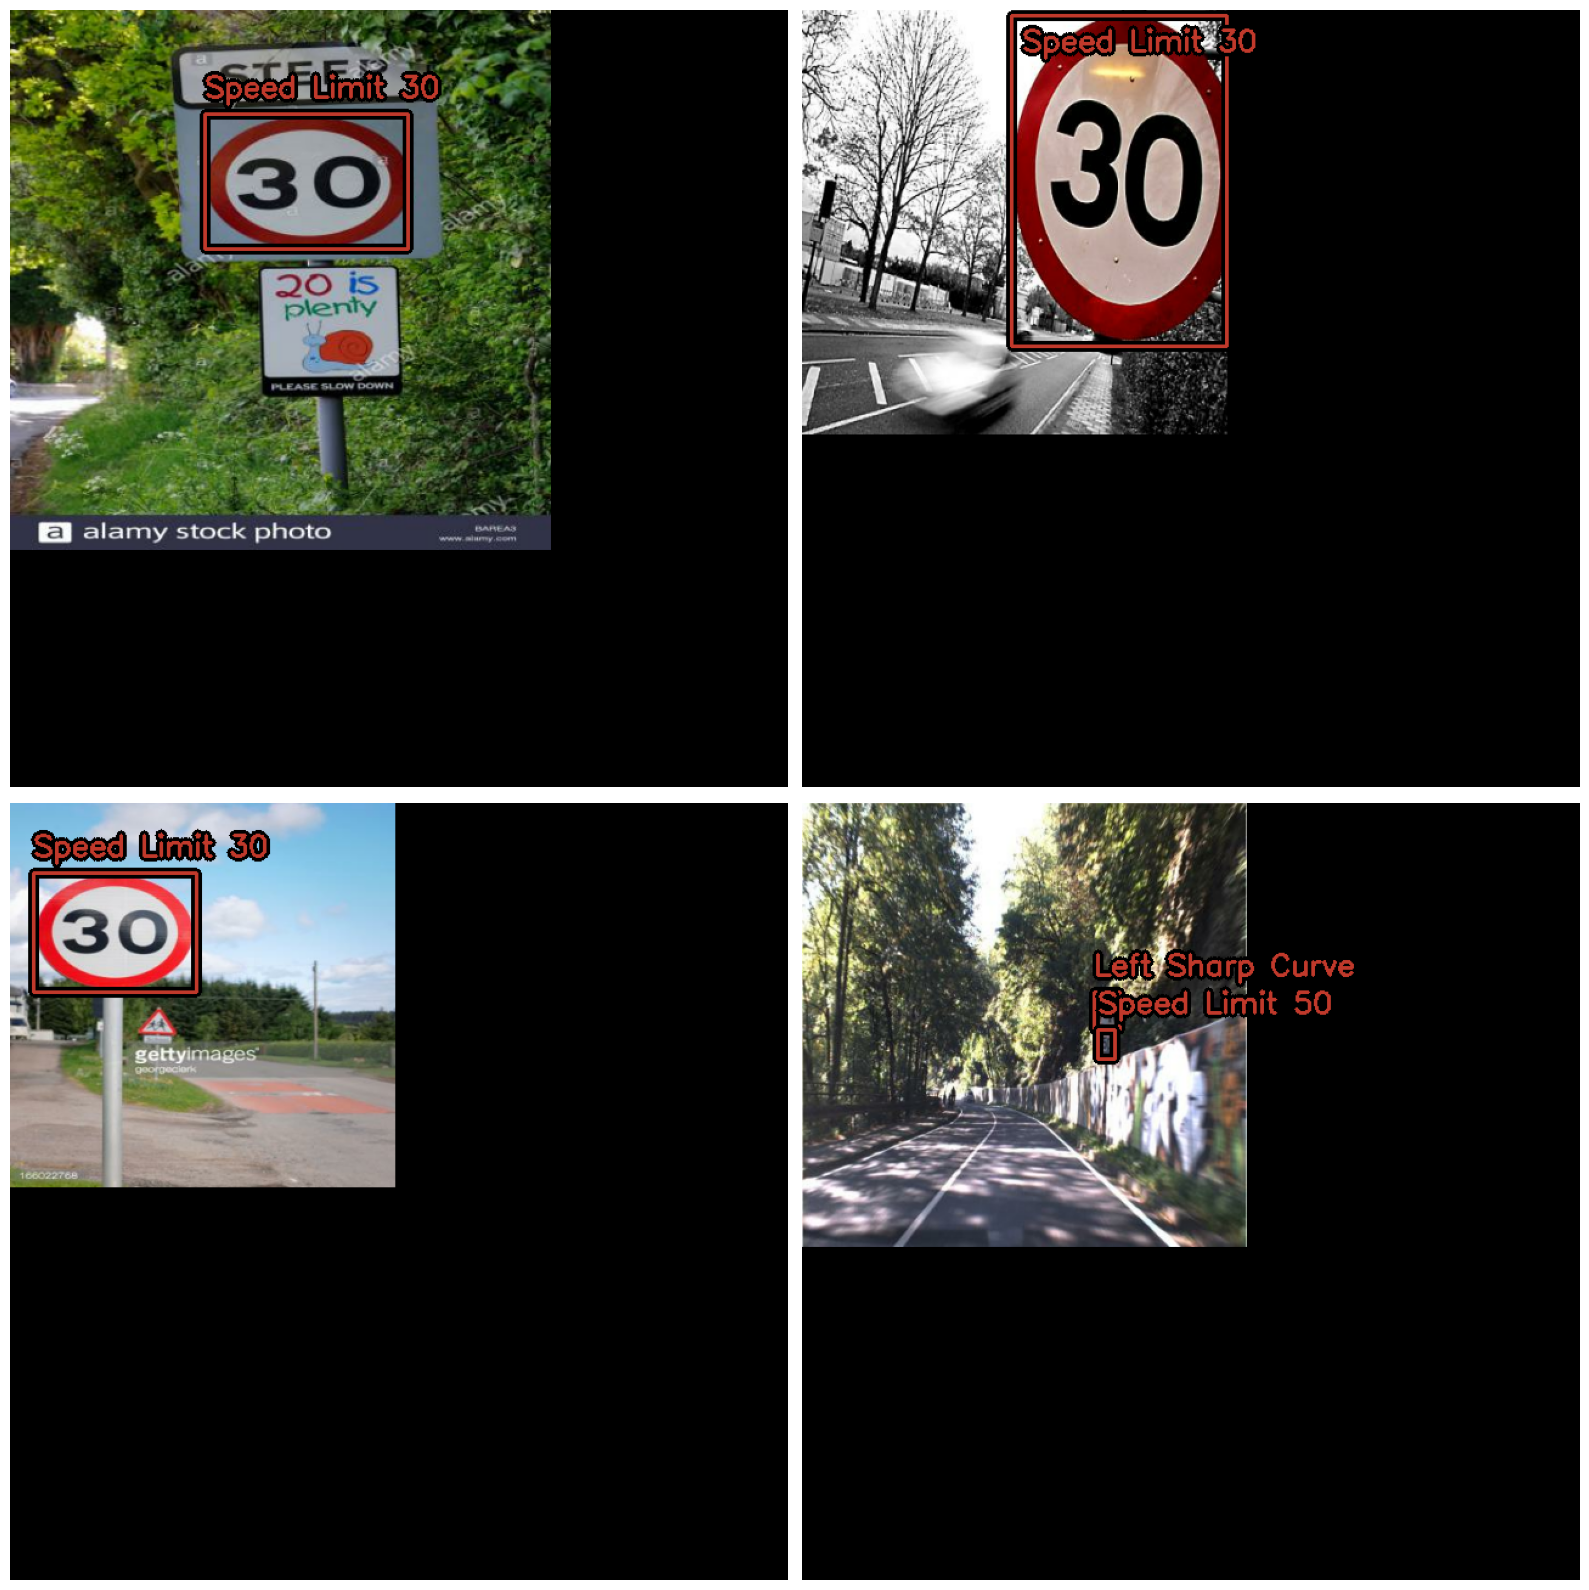

In [13]:
# examples images and annotations from training daatset
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

# <span style="color:#e74c3c;"> YOLO V8</span> Model


In [14]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Kiểm tra GPU

# Thiết lập mixed precision để tăng tốc độ trên GPU (tùy chọn)
tf.keras.mixed_precision.set_global_policy('float32')  #

Num GPUs Available:  0


In [16]:
def create_model(num_classes):
    # Tạo backbone với dtype policy rõ ràng
    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_m_backbone_coco",
        input_shape=(None, None, 3)  # Thêm input_shape cụ thể
    )

    # Tạo model với dtype policy
    YOLOV8_model = keras_cv.models.YOLOV8Detector(
        num_classes=num_classes,
        bounding_box_format="xyxy",
        backbone=backbone,
        fpn_depth=1
    )

    # Cấu hình optimizer
    optimizer = AdamW(
        learning_rate=0.001,
        weight_decay=0.004,
        global_clipnorm=GLOBAL_CLIPNORM
    )

    # Sử dụng loss với cast dtypes phù hợp
    YOLOV8_model.compile(
        optimizer=optimizer,
        classification_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        box_loss=keras_cv.losses.CIoULoss(bounding_box_format="xyxy"),
    )

    return YOLOV8_model


In [17]:
with tf.device('/device:GPU:0'):
  YOLOV8_model = create_model(num_classes = len(class_ids))

Download already complete (646 bytes).
Download already complete (47865512 bytes).


# <span style="color:#e74c3c;"> Training </span>

In [18]:
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset,  epochs = 10 )

Epoch 1/10


D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)


  2/348 ━━━━━━━━━━━━━━━━━━━━ 32:52 6s/step - box_loss: 7.1283e-05 - class_loss: 0.0397 - loss: 0.0398   


KeyboardInterrupt



# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'][1:])
axs[0].plot(hist.history['val_loss'][1:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
axs[1].plot(hist.history['box_loss'])
axs[1].plot(hist.history['val_box_loss'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
axs[2].plot(hist.history['class_loss'][1:])
axs[2].plot(hist.history['val_class_loss'][1:])
axs[2].legend(["train",  "validataion"])

# <span style="color:#e74c3c;"> Test </span> Predictions

In [ ]:
def visualize_predict_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))

    y_pred = model.predict(images)
    y_pred = keras_cv.bounding_box.to_ragged(y_pred)

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=class_mapping,
    )

In [ ]:
# red -> ground true
# yellow -> prediction

visualize_predict_detections(YOLOV8_model, dataset = test_dataset, bounding_box_format="xyxy")